# Project 1 - Regression
## Predict songs popularity

### 0. Packages,  Libraries and Formating

In [1]:
# Installing the necessary packages:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #visualizations
# using scikit-learn-intelex for improving performance with intel cpu
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split, cross_val_score
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import PredictionError
from sklearn import metrics
from yellowbrick.regressor import ResidualsPlot
from sklearn import tree
import graphviz

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Formating that will be applied in all of the notebook
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 15
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 12
heatmaps_text_fontSize = 12

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

# increase the number of columns to display
pd.set_option('display.max_columns', 500)

Reading data from the parquet file that we made, that has clean and encoded data that have already the data type setted.

In [3]:
ds = pd.read_parquet('ds.parquet.snappy', engine='fastparquet')

In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14456 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   song_popularity   14456 non-null  int64   
 1   song_duration_ms  14456 non-null  int64   
 2   acousticness      14456 non-null  float64 
 3   danceability      14456 non-null  float64 
 4   energy            14456 non-null  float64 
 5   instrumentalness  14456 non-null  float64 
 6   key               14456 non-null  category
 7   liveness          14456 non-null  float64 
 8   loudness          14456 non-null  float64 
 9   audio_mode        14456 non-null  category
 10  speechiness       14456 non-null  float64 
 11  tempo             14456 non-null  float64 
 12  time_signature    14456 non-null  category
 13  audio_valence     14456 non-null  float64 
dtypes: category(3), float64(9), int64(2)
memory usage: 1.4 MB


## 4. Modeling

The objetive of the model is to predict the song_popularity, so it was used to define the target variable:

In [5]:
# Target column
y = ds['song_popularity']

Since song_popularity is the target variable, it should be removed from the other variables dataset:

In [6]:
x = ds.drop(columns=['song_popularity'])

In [7]:
# Split the dataset intro train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, test_size = 0.25, random_state = 123)

#### 4.1 Select Modeling Techniques

Since we are working with a very small dataset we have decided to tune manually the tree, we ended up with a depth of 3 and a number of minimum samples per leaf of 38.
These numbers are small due to the fact that the with the small dimension of the dataset higher number lead to overfitting.

In [8]:
# Create the model
estimator = tree.DecisionTreeRegressor(random_state=123, max_depth=3, min_samples_leaf=38)

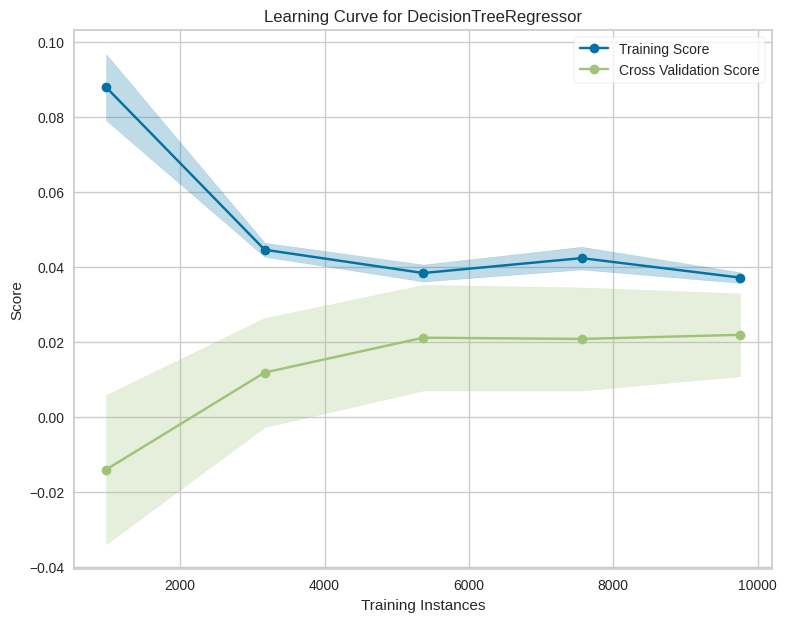

<Axes: title={'center': 'Learning Curve for DecisionTreeRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [9]:
# Plot the learning curve
fig, ax = plt.subplots(figsize=(9, 7))
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=estimator, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=-1, random_state=123)
visualizer.fit(X_train, y_train)
visualizer.show(ax=ax)

We can notice that the variance between training and cross validation is not so high, so we are not overfitting. On the other hand this score is very low, so we need more observations or more features in order to prevent underfitting.

In [10]:
# Create and train the model
estimator.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=38, random_state=123)

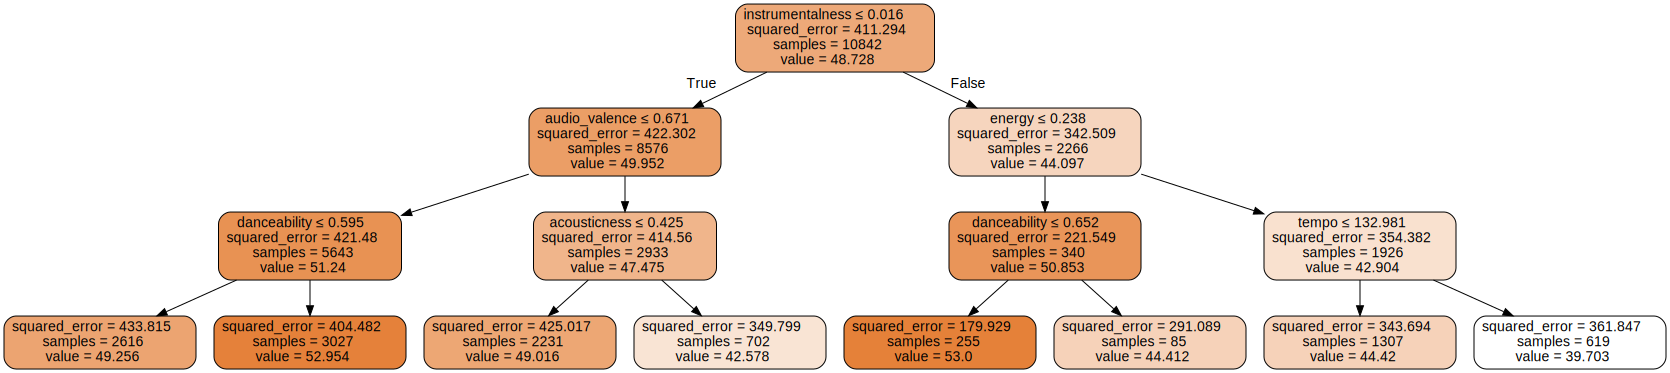

In [12]:
# Plot the tree
dot_data = tree.export_graphviz(estimator, out_file=None, 
                      feature_names=list(X_train.columns),  
                      class_names='Returns',  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

Here we can see the leaves and all the nodes with the features and the values selected for each features. All the predicted values will be on of this value that we have in leaves.

## 5. Evaluation

#### a. Evaluate Results

In [18]:
# predict y for X_train and X_test
y_pred_train = estimator.predict(X_train) 
y_pred_test = estimator.predict(X_test) 

In [19]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [20]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,1.576164e+01,1.611795e+01
1,RMSE,1.990759e+01,2.021477e+01
2,R^2,3.642550e-02,2.911384e-02
3,MAPE (%),3.324633e+15,3.528493e+15
4,MAX Error,5.342165e+01,5.300000e+01


The results of the measures shown above of train and test datasets are relatively close to each other, which indicates that train and test datasets have similar characteristics. The split of the data was done effectivelly.

In [21]:
# Visualize predictions vs target values 
temp = y_test.to_frame()
temp['Prediction'] = y_pred_test
temp['Residual'] = y_test - temp.Prediction
temp

,song_popularity,Prediction,Residual
6239,46,49.016136,-3.016136
10905,25,44.420046,-19.420046
4135,87,52.953750,34.046250
2163,69,52.953750,16.046250
12233,39,49.256116,-10.256116
...,...,...,...
6246,28,49.016136,-21.016136
54,69,49.256116,19.743884
13352,58,53.000000,5.000000
398,68,49.256116,18.743884


/home/ludotosk/anaconda3/envs/uni/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


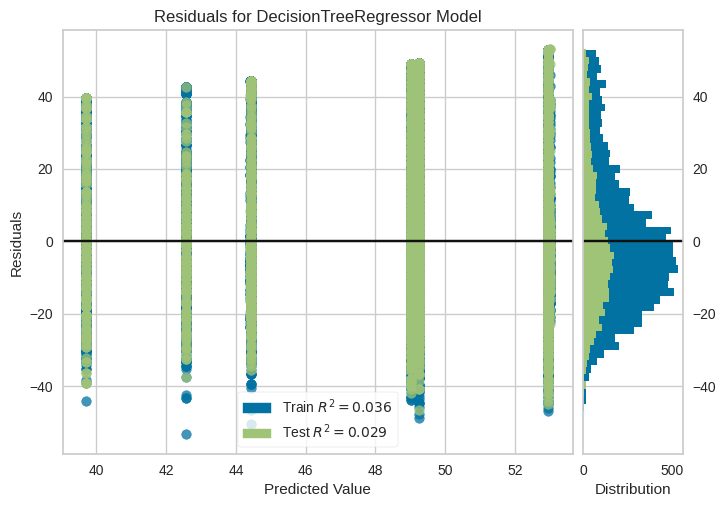

<Axes: title={'center': 'Residuals for DecisionTreeRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [22]:
# Visualize the residuals
residuals_vis = ResidualsPlot(estimator)
residuals_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
residuals_vis.score(X_test, y_test)  # Evaluate the model on the test data
residuals_vis.show() 

This graph above shows on the horizontal axis the value predicted, and we can see that goes between 35 and 60, and on the vertical axis the difference between the predicted value and the real one. The predicted values are represented in bars because they show the predicted values of the leaves, for example, if we have 20 leaves, we will have 20 bars. In this case, we are far from a good result.

/home/tosk/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names



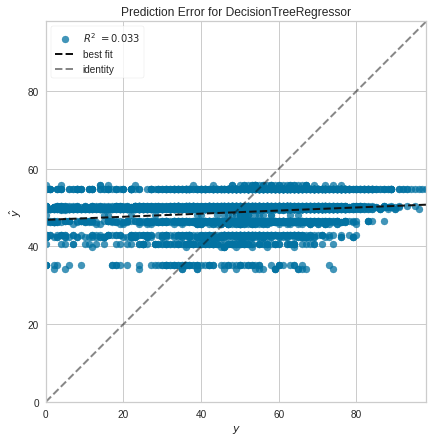

<AxesSubplot:title={'center':'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [20]:
# Visualize the prediction error
fig, ax = plt.subplots(figsize=(9, 7))
predError_vis = PredictionError(estimator)
predError_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
predError_vis.score(X_test, y_test)  # Evaluate the model on the test data
predError_vis.show(ax=ax)

The last graph is another vision of the graph before explaned. Here again we can see the same thing as the graph above, we have on the orizontal axis the real value and on the vertical one the predicted values. Again we can notice that all the predictions goes from nearly 40 to 60.